# Lab 5: (Advanced Session) How to Preprocess Raw Data for Training and Detection



## Introduction

In real-world business scenarios, the actual use case of anomaly detection might be very different, hence the collected raw data may be very different, which requires data analysis and preprocessing before used in model training.

In this session, we will discuss several common scenarios in general and show how to handle them properly, in order to inspire you to prepare the real data in your actual application.

***Estimated Lab Time***: 75 minutes

### Objectives
In this lab, you will:
- learn some basic technicals to perform data analysis and preprocessing
- Be able to prepare raw data into the format required for model training

### Prerequisites
- Be familiar with Python programming
- Have a Python or Anaconda environment to perform data analysis and preprocessing
    - User can either set it up on their local machine, or signup our Oracle [Data Science Platform](https://www.oracle.com/data-science/)
- Install a few Python libraries, such as `pandas`, `numpy`, `scipy`

## Task 1: Preparing Data

For the purpose of time-series anomaly detection, the collected data should mainly contain timestamp field, any measurements from signals, sensors, which have values that changes over time etc. Those signals or sensors should naturally come from a coherent and unified system/process that are representing the status of such unified complicated system/process.

Any other auxiliary fields such as categorical features (e.g., city names, zip codes, brands) or non-time-series numeric features (e.g, size of city, population count, or GPS locations) are not recommended; they can be together with sensor data to help understand the data or preprocess the data, but typically won't be used to build the anomaly detection models.

The collected data typically is a like 2-D matrix, where the first column stands for timestamp, and other columns are signals/sensors, and any additional supporting stationary/non-stationary attributes (which later will be suggested to remove). Each row should represent one observation of the whole system for a given timestamp, which contains the values for different signals captured in that timestamp, along with the other supporting columns.

However, in reality, the data may come from different data sources, with different formats that not match with our requirements. We first suggest user to understand the meaning of datasets, attributes, observations, and data types. Based on the actual scenario, they use may need to take the following recommendations and check the examples.

***Note***: All the data files needed in this session can be downloaded here:
* [Example data](../files/example.csv) : an example data to show missing values, data status, distributions, monotonic attributes, etc.
* [Building temperature data](../files/building_temperature.csv): temperature data for 2 buildings for later combination
* [Building pressure data](../files/building_pressure.csv): pressure data for 2 buildings for later combination

### Loading single data source
Data can come from different data sources, resulting into different formats, such as database tables, json documents, csv/txt files, etc. For our analysis, those non-csv file formats should be converted into a 2-D matrix format and saved into csv files for next step. Domain knowledge may be required to do the proper conversion.

**Example of Data loading**

Loading the data with dataframe from csv file.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import random
import json
import os

In [2]:
 !pip install seaborn

In [42]:
# Please specify the data path of the files you downloaded
DATA_PATH = '/home/datascience/files/'

file_name = DATA_PATH + 'example.csv'
print(file_name)

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
example_df = pd.read_csv(file_name, parse_dates=['timestamp'], date_parser=dateparse)
example_df.head()

/home/datascience/files/example.csv


FileNotFoundError: [Errno 2] No such file or directory: '/home/datascience/files/example.csv'

### Combine different data sources
In case the data are from difference data source, the user needs to combine them properly. The general guideline is to have a single data table where each row represents a timestamp to show how all the different signals/components behave, and each column is just one specific signal/sensor/attribute such that its value shows in a chronological order.

In many real cases (such as data from database Cassandra or InfluxDB), those datasets may have 3 or more columns like the following:
* timestamp
* sensor_name (key)
* sensor_value (value)

In those cases, we need to normalize the data files properly to have cohesive timestamp and attributes, and here are one example to show one way of combining those data.

**Example**

Assume we have the following data files:
* file1 with information of pressure sensor 1 to 6 for building 1 and building 2
* file2 with information of temperature sensor 1 to 4 for building 1 and building 2


In [4]:
file_name = DATA_PATH + 'building_temperature.csv'

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
raw_temerature_df = pd.read_csv(file_name, parse_dates=['timestamp'], date_parser=dateparse)
raw_temerature_df.head(5)

,timestamp,building_name,sensor_name,sensor_value
0,2019-01-01 10:00:00,building1,temperature_1,40.1746
1,2019-01-01 10:00:00,building1,temperature_2,44.2003
2,2019-01-01 10:00:00,building1,temperature_3,42.2857
3,2019-01-01 10:00:00,building1,temperature_4,48.0491
4,2019-01-01 10:00:00,building1,temperature_5,49.1427


In [5]:
file_name = DATA_PATH + 'building_pressure.csv'

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
raw_pressure_df = pd.read_csv(file_name, parse_dates=['timestamp'], date_parser=dateparse)
raw_pressure_df.head(5)

,timestamp,building_name,sensor_name,sensor_value
0,2019-01-01 10:00:00,building1,pressure_1,107.4260
1,2019-01-01 10:00:00,building1,pressure_2,82.2464
2,2019-01-01 10:00:00,building1,pressure_3,68.8326
3,2019-01-01 10:00:00,building1,pressure_4,82.9828
4,2019-01-01 10:00:00,building1,pressure_5,118.4210


#### Step A: Put individual sensor into its own column

In [6]:
def convert_df_to_sensor_columns(df):
    # Assume the building name is always same in this df
    df_multidx = df.copy(deep=False).set_index(['timestamp', 'building_name', 'sensor_name'])[:]
    newdf = pd.DataFrame(pd.Series(df_multidx.values.reshape(-1,), index=df_multidx.index), columns=['sensor_value'])
    newdf = newdf.unstack(level=-1)
    newdf.columns = [name for (_, name) in newdf.columns] # No need 2-tuple name for column name
    newdf.reset_index(inplace=True) # Get timestamp and building_name as regular column
    return newdf

new_temperature_df = convert_df_to_sensor_columns(raw_temerature_df)
new_pressure_df = convert_df_to_sensor_columns(raw_pressure_df)
new_pressure_df.head()

,timestamp,building_name,pressure_1,pressure_2,pressure_3,pressure_4,pressure_5
0,2019-01-01 10:00:00,building1,107.4260,82.2464,68.8326,82.9828,118.4210
1,2019-01-01 10:00:00,building2,93.3252,107.4895,101.2728,103.6401,118.9729
2,2019-01-01 12:04:00,building1,95.4847,115.2700,92.5658,96.5299,108.9100
3,2019-01-01 12:04:00,building2,103.9656,99.8513,110.2489,81.7845,108.4648
4,2019-01-01 14:00:00,building1,108.2850,90.8498,113.5338,105.5288,105.9302


#### Step B: Join two dataframes together

In [7]:
new_combined_df = new_temperature_df.join(new_pressure_df.set_index(['timestamp', 'building_name']), 
                                          on=['timestamp', 'building_name'], how='outer')
new_combined_df = new_combined_df.sort_values(by='timestamp', ignore_index=True)
new_combined_df.head(5)

,timestamp,building_name,temperature_1,temperature_2,temperature_3,temperature_4,temperature_5,pressure_1,pressure_2,pressure_3,pressure_4,pressure_5
0,2019-01-01 10:00:00,building1,40.1746,44.2003,42.2857,48.0491,49.1427,107.4260,82.2464,68.8326,82.9828,118.4210
1,2019-01-01 10:00:00,building2,43.5483,38.7111,44.8513,46.5925,36.1578,93.3252,107.4895,101.2728,103.6401,118.9729
2,2019-01-01 12:04:00,building1,40.3374,36.9857,38.2883,49.7044,43.2163,95.4847,115.2700,92.5658,96.5299,108.9100
3,2019-01-01 12:04:00,building2,44.2044,42.8381,37.6925,45.5218,46.4769,103.9656,99.8513,110.2489,81.7845,108.4648
4,2019-01-01 14:00:00,building1,38.6388,49.3813,41.7175,39.1863,47.1067,108.2850,90.8498,113.5338,105.5288,105.9302


### Separate data for different models

In some cases that the data should be maintained as separated or even split into different sub-systems or sub-components, and later be used to build separate anomaly detection models.  The rationale is that our multivariate anomaly detection algorithm  is aiming to learn the dynamics and correlations between attributes in the training data.

* Attributes from a single system or inter-connecting to each other can stay in the same dataset to build the model.
* On the other hands, if attributes can be grouped into different sub-systems which are very loosely connected or simply independent, then those groups of attributes should stay separate and train models separately.

For example, in a large HVAC monitoring system that supports multiple buildings in a university campus, it is obvious to split sensors into different buildings separately to train different models. Combining those sensors together for a single model may likely leads to bad model performance.

In the above case, it seems there are two different buildings, and pressure and temperature readings are likely independent between buildings. We would recommend to split the data to train separate model.


In [8]:
combined_building1_df = new_combined_df[lambda x: x.building_name == 'building1'][:].reset_index(drop=True)
combined_building2_df = new_combined_df[lambda x: x.building_name == 'building2'][:].reset_index(drop=True)
combined_building2_df.head(6)

,timestamp,building_name,temperature_1,temperature_2,temperature_3,temperature_4,temperature_5,pressure_1,pressure_2,pressure_3,pressure_4,pressure_5
0,2019-01-01 10:00:00,building2,43.5483,38.7111,44.8513,46.5925,36.1578,93.3252,107.4895,101.2728,103.6401,118.9729
1,2019-01-01 12:04:00,building2,44.2044,42.8381,37.6925,45.5218,46.4769,103.9656,99.8513,110.2489,81.7845,108.4648
2,2019-01-01 14:00:00,building2,49.3398,43.6821,49.4704,46.8524,38.6499,102.5381,108.5772,102.6563,104.3309,78.1749
3,2019-01-01 16:05:00,building2,44.0298,42.0483,42.9457,39.4220,45.0344,105.2351,76.1339,95.0577,94.7237,82.4337
4,2019-01-01 18:01:00,building2,42.8496,49.0936,46.8881,48.5843,45.6018,103.6058,109.8257,112.5301,100.2707,85.4824
5,2019-01-01 20:01:00,building2,46.6364,37.3295,40.5927,42.9285,40.1532,95.8819,86.6172,92.6144,97.0362,91.7113


### Align timestamp and/or time frequency

If the frequency of timestamp are different for different signals, we need to align them properly.

One basic way if that is to use all the unique timestamps from different data sources, and fill in with last value if the timestamp is not collected for a particular signal.

Other methods involve to up-sample the timestamp at a coarse level, such as only select one value for any minutes if the signals are collected at minutes or seconds level. However, the user needs to understand such up-sampling need to align with domain knowledge or business use case, so that the anomaly detection won't impact the real usage.

**Example**

In above example, the two dataframes on temperature and pressure has the same frequency (one reading a day), but the timestamps are not well aligned: they are always off by 1 minute to 8 minutes.

Let's say, based on domain knowledge, this small minute off may not have any business impacts, and the sensor values are approximately stable in every few minutes window.

Then as suggested, one easy way is to use all of the unique timestamps, and fill the attributes that do not have values for certain timestamps with past values. However, once we perform this, the time frequency will be altered, some days only have one record, some days have two records; we should drop one record and maintain the original frequency: once per day.

Note: Since our algorithm/service also support missing values, the user can also leave those missing values for some timestamps as is.


In [9]:
# Drop no-use attributes
combined_building1_df.drop(['building_name'], inplace=True, axis=1)

# Backfill missing values due to timestamp are not aligned
combined_building1_df.bfill(inplace=True) # Note, this step may not be needed, as our algorithm can also fill missing values

# Add a key to help remove row with duplicated days
combined_building1_df['date_till_hour'] = combined_building1_df['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H'))
combined_building1_df.drop_duplicates(subset='date_till_hour', keep='first', inplace=True)
combined_building1_df.drop(['date_till_hour'], inplace=True, axis=1)
combined_building1_df.head()

,timestamp,temperature_1,temperature_2,temperature_3,temperature_4,temperature_5,pressure_1,pressure_2,pressure_3,pressure_4,pressure_5
0,2019-01-01 10:00:00,40.1746,44.2003,42.2857,48.0491,49.1427,107.4260,82.2464,68.8326,82.9828,118.4210
1,2019-01-01 12:04:00,40.3374,36.9857,38.2883,49.7044,43.2163,95.4847,115.2700,92.5658,96.5299,108.9100
2,2019-01-01 14:00:00,38.6388,49.3813,41.7175,39.1863,47.1067,108.2850,90.8498,113.5338,105.5288,105.9302
3,2019-01-01 16:05:00,41.2899,49.3942,37.3080,46.2660,40.6187,97.5775,82.8489,103.1098,98.8703,89.1356
4,2019-01-01 18:01:00,38.9499,40.9180,39.9061,46.6894,49.0726,105.2541,93.6006,93.2559,115.8786,82.7962


As suggested, your data need to be in CSV format, and first line should be the header, starting with `timestamp` as first column. 

Other column is representing a signal/sensor or attribute. 

Each row represents an observation of the system, with values of those signals/sensors/attributes aligned properly. We also support JSON format, which later will explain what that format looks like.

##  **STEP 2:** Exploring Data

After the data being loaded, we now can start basic exploration to validate and identify potential issues of the data.

There are many ways of data exploration, and can be very dependent on particular business scenarios.

Here we only introduce some basic methods which are appropriate to time-series data.

**Check data types and missing values**

    * Use the following command, one can understand the data types being loaded and any non-nullable values.

In [10]:
file_name = DATA_PATH + 'example.csv'

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
example_df = pd.read_csv(file_name, parse_dates=['timestamp'], date_parser=dateparse)
example_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  500 non-null    datetime64[ns]
 1   sensor1    500 non-null    float64       
 2   sensor2    500 non-null    float64       
 3   sensor3    500 non-null    float64       
 4   sensor4    500 non-null    float64       
 5   sensor5    500 non-null    float64       
 6   sensor6    500 non-null    float64       
 7   sensor7    500 non-null    float64       
 8   sensor8    500 non-null    float64       
 9   sensor9    500 non-null    float64       
 10  sensor10   478 non-null    float64       
 11  sensor11   25 non-null     float64       
 12  location   500 non-null    object        
 13  status     500 non-null    object        
dtypes: datetime64[ns](1), float64(11), object(2)
memory usage: 54.8+ KB


In [11]:
example_df.describe()

,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,478.000000,25.000000
mean,0.163042,0.145753,0.164147,0.165664,0.133664,0.166875,0.156911,0.000000,0.009245,-0.026995,0.474572
std,0.908563,0.837650,0.828226,0.838714,0.834534,0.819496,0.840272,1.158172,1.751856,6.660626,0.263944
min,-2.637500,-2.536400,-2.142900,-2.075600,-2.015000,-1.960500,-2.185800,-2.000000,-3.538800,-60.000000,0.092400
25%,-0.522425,-0.448225,-0.421400,-0.457625,-0.458450,-0.442050,-0.420900,-1.000000,-1.477050,-0.449025,0.238100
50%,0.268850,0.212050,0.167650,0.209700,0.189500,0.259050,0.196950,0.000000,-0.001700,0.229800,0.472600
75%,0.872075,0.773800,0.780675,0.792300,0.750450,0.793375,0.828275,1.000000,1.543950,0.809350,0.657800
max,2.652600,2.211700,2.056400,1.999700,2.150300,2.127200,2.454200,2.000000,3.617800,100.110000,0.949400


This function will show basic data stats, any missing values, min or max values, and average and other quantile values. One can quickly use that to verify if any attributes are questionable or invalid from business point of view.

If there are significantly number of missing values of one attribute, one might need to think what was the reason and either drop it or fill with valid values.

In this example, the sensor11 has 25 values (others are missing value), use may remove this sensor or identify the reason of why those values are missing.


In [12]:
example_df.count() / len(example_df)

timestamp    1.000
sensor1      1.000
sensor2      1.000
sensor3      1.000
sensor4      1.000
sensor5      1.000
sensor6      1.000
sensor7      1.000
sensor8      1.000
sensor9      1.000
sensor10     0.956
sensor11     0.050
location     1.000
status       1.000
dtype: float64

In [13]:
example_df.drop(['sensor11'], inplace=True, axis=1)

#### Plot distributions of every attribute
Use the following function to plot the distribution of every attribute to understand if the value ranges and distribution are making sense or not.


array([[<AxesSubplot:title={'center':'sensor1'}>,
        <AxesSubplot:title={'center':'sensor2'}>,
        <AxesSubplot:title={'center':'sensor3'}>],
       [<AxesSubplot:title={'center':'sensor4'}>,
        <AxesSubplot:title={'center':'sensor5'}>,
        <AxesSubplot:title={'center':'sensor6'}>],
       [<AxesSubplot:title={'center':'sensor7'}>,
        <AxesSubplot:title={'center':'sensor8'}>,
        <AxesSubplot:title={'center':'sensor9'}>],
       [<AxesSubplot:title={'center':'sensor10'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

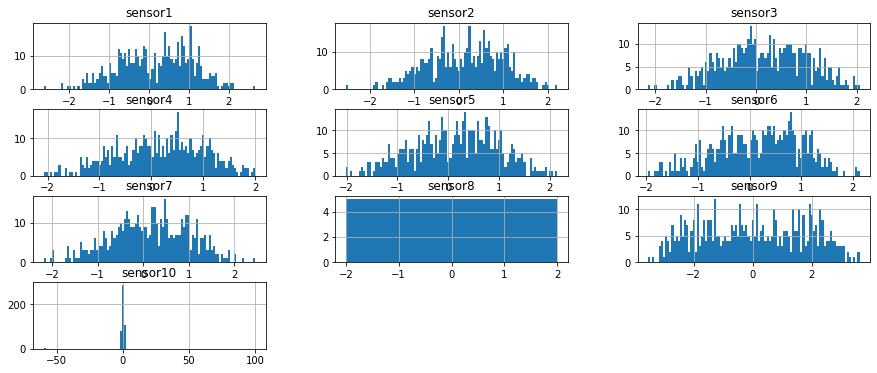

In [29]:
sensor_cols = [e for e in example_df.columns if e != 'timestamp']
example_df[sensor_cols].hist(bins=100, figsize=(15, 6))

![](../images/lab2-data-distribution-image.png)

In this above example, the sensor10 seems to have a much wider range than other, more deeper check may reveal what happens.

In [30]:
example_df[['sensor10']].apply(pd.Series.value_counts, bins=[-60, -20, -5, 0, 0.5, 1])

,sensor10
"(-5.0, 0.0]",193
"(0.5, 1.0]",103
"(0.0, 0.5]",103
"(-60.001, -20.0]",3
"(-20.0, -5.0]",0


It looks like that there are some extreme values in the [-60, -5] range, we can filter them out based on domain knowledge.


In [31]:
example_df[lambda x: x['sensor10']<-5][:].head()

,timestamp,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,location,status
97,2018-04-10 16:00:00,0.7468,1.2587,0.3632,0.2091,1.2539,0.4938,1.0273,1.2224,-2.5654,-60.0,building1,active
142,2018-05-25 16:00:00,0.4374,-0.6623,0.2805,-0.2146,0.1622,-0.3386,-0.2518,0.8617,-1.0349,-60.0,building1,active
191,2018-07-13 16:00:00,-0.3555,-0.3829,-1.3414,-0.6930,-0.9549,-0.0544,-0.4447,0.4689,-0.2439,-60.0,building1,active


#### Plot data on time window
For time-series data, it is necessary to plot each attribute on the timestamp axis to see the data trend, gaps, or any other issues. Since we require the first column to be timestamp, one can run the following example to plot the data.


<AxesSubplot:xlabel='timestamp'>

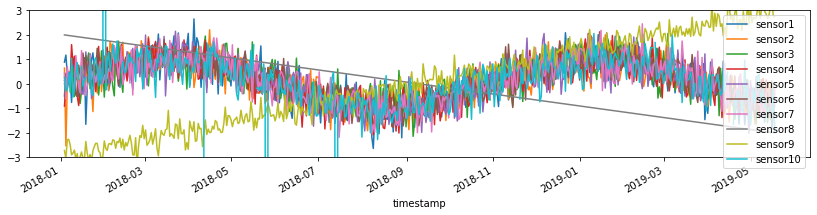

In [32]:
example_df.plot(x='timestamp', figsize=(14,3), ylim=[-3, 3]) # Plot all numeric data

![](../images/lab2-time-series-plot.png)


**Recommendations:**

When observing the plots, pay attention to the data points don't follow the trends/patterns, the overall trends if they are monotonically increasing or decreasing, and any gapped period in the data.
* You can ploy individual column separately to observe the pattern more clearly if the number of attributes are not too many.
* If there are too many attributes, you may put them in different groups based on certain characteristics (such as type, location, etc.) and select a few representative attributes from each group to observe.
* If you observe some problematic in those attributes, you may pick more to confirm your conclusions and use the following scenarios to resolve them.


#### Monotonic Attributes

Based on the graph of time-series, one may identify monotonic features, which may not be useful for model training, and can be removed.

<AxesSubplot:xlabel='timestamp'>

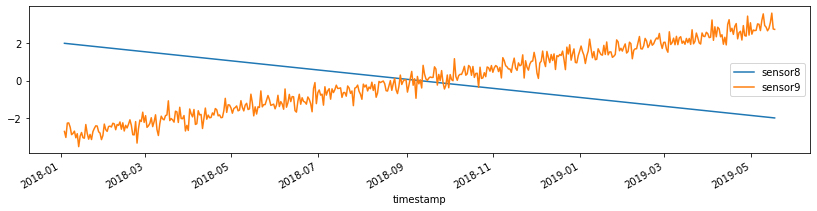

In [33]:
example_df[['timestamp', 'sensor8', 'sensor9']].plot(x='timestamp', figsize=(14,3)) # Plot individual column

![](../images/lab2-time-series-plot2-motonic-signals.png)

**Example**

In the above example, sensor8 is a monotonically decreasing attribute, which doesn't correlate with other signals. In this, case it is suggested to remove before model training.

However, sensor9 seems to be "monotonic", but it does have fluctuations around this whole time series. This trend suggests that we may not seeing the full value range of sensor9 (it seems will keep going up after the training window).

Therefore, this attribute is not suitable for model training, and the user should ask for more data to have the full value range in the dataset before training the model. Otherwise, training on this data may lead to high false positives.


### Feature Correlation

A little bit more advanced technique is to calculate correlations between the signals/attributes, and check them with domain knowledge to verify its consistency. This could also potentially identify data problems before training the model.

**Example**

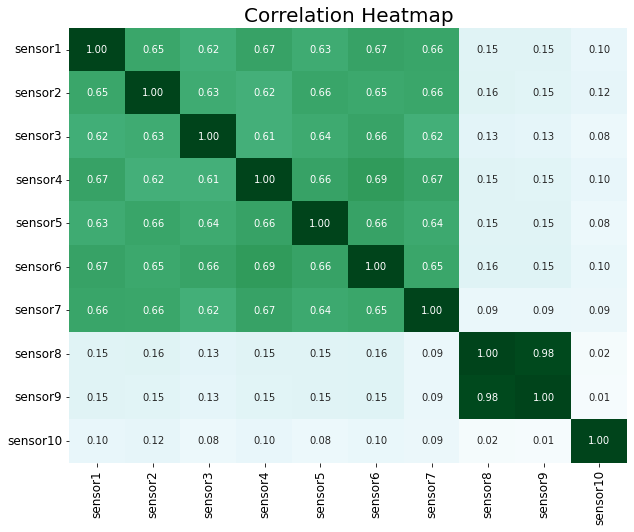

In [34]:
corr = example_df.corr()

import seaborn as sns


%matplotlib inline

# plot the heatmap
plt.figure(figsize = (10, 8))

sns.heatmap(corr.abs(), cmap='BuGn', cbar=False, vmin=0, vmax=1, annot=True, fmt='.2f')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

![](../images/lab2-feature-correlation-heatmap.png =800x800)

In this heatmap, it seems that sensor8 and sensor9 have a strong correlation; and it was found to be true in real business scenario (the two sensors are physically close).


##  **STEP 3:** Preprocessing Data

After having basic understanding on the data, we can start to preprocess and clean the data to fit for model training.

### Keep only the timestamp and valid numeric sensor/signal attributes

As mentioned, our multivariate anomaly detection algorithm require only the timestamp and numeric data, we should only keep those attributes for future processing.

Meanwhile, if the sensor attributes are mostly NULL or NAN values (e.g., more than 50%), we should also consider to drop them.


In [35]:
# Example of removing all null columns
null_cols = example_df.columns[example_df.isnull().all()] # identify columns thare all null
print(null_cols)
example_df.drop(null_cols, axis = 1, inplace = True) # drop nan columns in place

Index([], dtype='object')


In [36]:
# Example of keeping only the timestamp and numeric columns
# Only keep timestamp, and numeric sensor columns
valid_sensor_columns = [col for col, typ in example_df.dtypes.items() if (col == 'timestamp') or 
                        (typ == 'float64' or typ == 'float32' or typ == 'int64') ]
data_df = example_df[valid_sensor_columns].copy()
data_df.head()

,timestamp,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10
0,2018-01-03 16:00:00,0.8885,0.6459,-0.0016,-0.9061,0.1349,-0.4967,0.4335,2.0000,-2.7237,0.2734
1,2018-01-04 16:00:00,1.1756,-2.5364,-0.1524,-0.0804,-0.2209,0.4321,-0.6206,1.9920,-3.0462,-0.3083
2,2018-01-05 16:00:00,0.4132,-0.0290,0.2968,0.3098,-0.1143,-0.1990,0.7020,1.9840,-2.2769,-0.1828
3,2018-01-06 16:00:00,0.2385,0.0092,0.4114,0.4846,0.4818,0.2670,0.1959,1.9760,-2.2664,0.4710
4,2018-01-07 16:00:00,0.3327,0.4728,0.3623,0.1414,0.1824,-0.0412,0.2011,1.9679,-2.4895,-0.3409


### Remove invalid observations

Based on previous distribution analysis, if some values of a particular attribute is not valid, either due to data collection issues, or default value when service is not available, one can remove those observations.

Some examples can be like the following:


In [37]:
clean_df = example_df[lambda x: ~pd.isna(x['sensor10'])][:] # remove missing value rows

clean_df = example_df[lambda x: x['sensor4']>0][:] # remove observations with negative values in sensor4

clean_df = example_df[lambda x: (x['sensor1']>0) & (x['sensor2']<0) ][:] 
# remove observations with negative values in column1 and positive values in column2

For example, we know in sensor10, there are some extreme values, and let say from domain perspective, it deemed as invalid and should be removed.


In [38]:
clean_df = data_df[lambda x: (x['sensor10'] > -5) & (x['sensor10'] < 5)][:]
clean_df.shape

(474, 11)

### Remove known outliers/anomalies from training set

With above various analysis approaches, if the user found any known outliers by exploration or domain knowledge, it is suggested to remove outliers before model training. For testing data, those outliers can be kept as is to verify result or check model performance, but not in training data.

The examples of removing outliers are similar to above. For example, if we know if sensor1 bigger than 2 are anomaly in real business scenario, one can remove it:


In [39]:
clean_df = clean_df[lambda x: x['sensor1'] <= 2][:]
print(clean_df.shape)
clean_df.head()

(468, 11)


,timestamp,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10
0,2018-01-03 16:00:00,0.8885,0.6459,-0.0016,-0.9061,0.1349,-0.4967,0.4335,2.0000,-2.7237,0.2734
1,2018-01-04 16:00:00,1.1756,-2.5364,-0.1524,-0.0804,-0.2209,0.4321,-0.6206,1.9920,-3.0462,-0.3083
2,2018-01-05 16:00:00,0.4132,-0.0290,0.2968,0.3098,-0.1143,-0.1990,0.7020,1.9840,-2.2769,-0.1828
3,2018-01-06 16:00:00,0.2385,0.0092,0.4114,0.4846,0.4818,0.2670,0.1959,1.9760,-2.2664,0.4710
4,2018-01-07 16:00:00,0.3327,0.4728,0.3623,0.1414,0.1824,-0.0412,0.2011,1.9679,-2.4895,-0.3409


#### How much data to remove/clean?

In this whole cleaning step, the main purpose to clean/remove observations are removing invalid rows and known outliers based on domain knowledge.

If there are too many invalid rows to be removed, one need to understand why and may need to correct the underneath root cause (e.g., if there is data collection problem, they can use better sensor brands/types.)

On the other hand, if there are too many known outliers to be removed, one need to check from business perspective, does it match with the reality?

For example, if in the actual business case, such anomaly or fault indeed happens frequently, then this is as expected. Otherwise, they need to check whether data has issues, or use the same ball park numbers to remove anomaly observations.

**Recommendations**

Generally speaking, the user should not remove no more than ~1%-5% outliers/anomalies from the data. If more than this, they need to double-check what conditions being used and be more conservative to remove.


##  **STEP 4:** Final Splitting and Formatting

Typically in general ML model development, data is split into training and testing set, so that ML models are trained from training set, and to be fair, performance are evaluated on the testing set.

Similarly here, we suggest user to pick a reasonable timestamp to split data into the two sets. Then user can prepare the training data and testing data separately with similar approaches above, but for testing data, there is no need to remove known outliers/anomalies.

The user can also use all of their historical data as training set to build ML models, and then use production/live data for actual anomaly detection use case. However, we only suggest to use this approach after several iterations of model development to verify the model performance is satisfying the business case.

### Data Splitting

In order to learn the full pattern of data and train a high performant model, we require the training set should have the full value range for every attribute. Once this condition is satisfied, the user can pick a timestamp to split the data, e.g., maintaining a 70%/30% training-testing ratio, or up to 90%/10%.


In [40]:
split_ratio = 0.9
split_idx = int(combined_building1_df.shape[0] * split_ratio)
train_building1_df = combined_building1_df[0:split_idx]
test_building1_df = combined_building1_df[split_idx:]
print(f"training set size: {train_building1_df.shape}, testing set size: {test_building1_df.shape}")

training set size: (6300, 11), testing set size: (700, 11)


### Formatting

Currently, our anomaly detection service takes 2 types of data format, CSV format, or JSON format.

#### CSV Format
The CSV format is similar to the dataframe preprocessed by above steps. No extra steps is needed.
* The CSV file need to head the header row, with first column as `timestamp`
* Each row is one observation of all attributes at the particular timestamp.
* Missing value is allowed, simple ignore it

Example of csv file:
```CSV
timestamp,signal1,signal2,signal3,signal4,signal5,signal6,signal7,signal8,signal9,signal10
2020-01-01 13:00:01,1,1.1,2,2.2,3,3.3,4,4.4,5,5.5
2020-01-01 13:01:00,1,1.1,2,2.2,3,3.3,4,4.4,,
2020-01-01 13:02:02,,1.12,2,2.02,3.01,3.32,4,,5.01,5.54
...
```

#### JSON Format
The JSON format is also straight-forward, it contains a key `columnLabels` listing all attribute names, and a key `data` to list all acutual values along with timestamp.

```Json
{
    "requestType": "INLINE",
    "columnLabels": [ "sensor1", "sensor2", "sensor3", "sensor4", "sensor5", "sensor6", "sensor7", "sensor8", "sensor9", "sensor10" ],
    "data": [
        {
            "timestamp": "2018-01-03T16:00:01Z",
            "value": [ 0.8885, 0.6459, -0.0016, -0.9061, 0.1349, -0.4967, 0.4335, 0.4813, -1.0798, 0.2734 ]
        },
        {
            "timestamp": "2018-01-03T16:00:02Z",
            "value": [ 0.8825, 0.66, -0.01, -0.9161, 0.1349, -0.47, 0.45, 0.4234, -1.1339, 0.3423 ]
        }
      ]
}
```

Here is a simple function to convert the dataframe into this JSON format.


In [41]:
def convert_df_to_json(df, outfile_name):
# NOTE: Assume the first column or the index in dataframe is the timestamp, will force to change it as timestamp in output
    out_json = {'requestType': 'INLINE', 'columnLabels': [], 'data': []}
    column_0 = list(df.columns)[0]
    if df.index.name == None:
        df.index = df[column_0]
        df.drop([column_0], inplace=True, axis=1)
    out_json['columnLabels'] = list(df.columns)
    out_json['data'] = [{'timestamp': index.strftime('%Y-%m-%dT%H:%M:%S.000Z'), 'value': list(row.values)} for index, row 
                        in df.iterrows()]

    with open(outfile_name, 'w') as file:
        file.write(json.dumps(out_json, indent=2))
    print(f"JSON output file save to {outfile_name}")
    return out_json

#### Final Data Samples
After those above steps, you should now be able to transform the raw data provided earlier to be like the following:

* [processed training csv data](../files/demo-training-data.csv)
    - 11 signals with timestamp column, with 7299 observations
* [processed testing json data](../files/demo-testing-data.json)
    - same 11 signals with timestamp column, 100 observations

Congratulations on completing this lab! You now have finished all the sessions of this lab, please feel free to contact us if any additional questions.


## Acknowledgements
* **Authors**
    * Jason Ding - Principal Data Scientist - Oracle AI Services
    * Haad Khan - Senior Data Scientist - Oracle AI Services
* **Last Updated By/Date**
    * Jason Ding - Principal Data Scientist, May 2021
